This notebook shows how to run btk from with an input config yaml file. The config file contains information on how to simulate the blend scene, which detecteion/deblending algorithm to run and where to load from/save to "./data". The config file is parsed by `btk_input.py` for end-to-end analysis; from image simulation to saving the measurement output to file. To perfoem comparitive analysis across different algorithms:

1. Make a copy of the config file `..btk/btk-config.yaml`
2. Modify entries under `user_input:` to run your desired detection algorithm. `measure_function` and `metrics_function` must be either None (to select Default) or should be classes defined in `utils_filename`.

The detection and metric outputs will be saved inside "output_dir/output_name". The simulation parameters in `..btk/btk-config.yaml` must remain the same when comparing algorithms.

For this example however, we use an input config file `../input/example-config.yaml`, with fewer test runs. 
The config values are:

```
user_input:
    # Enter location to load dataset from (relative to where you open the yaml file)
    data_dir: data
    # Enter location where btk test output should be saved
    output_dir: example-output
    # Enter file name containing user function to perform detection/deblending/measurement
    utils_filename: # If None use btk/utils.py
    output_name: trial  # btk output will be saved in a directory with this name inside output_dir
    # Enter name of functions to perform detection/deblending/measurement.
    utils_input:
        measure_function: SEP_params
        metrics_function: None
```
The config directs btk to perform detections with SEP band-coadd images by specifying `measure_function: SEP_params` defined in `btk.utils`. The config entry `metrics_function: None`, specifies that the `Basic_measure_params` in `btk.utils` computes the detection metrics.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
import btk.plot_utils, btk.utils
import astropy.table
import dill


The config file contains parametrs for three types of input test images:
1. two-galaxy blend created randomly from CatSim galaxies
2. Upto 10 galaxy blends created randomly from CatSim galaxies
3. blends as galaxy "groups" from a pre-processed wld output

## 1. Two-galaxy blend created randomly from CatSim galaxies

`btk_input.py` input arg `--two_gal` simulates galaxy blends using the `btk.utils.default_sampling` function with maximum of 2 sources per blend. The yaml config file is input with the `--configfile` arg. The class name with functons on how to run the detection algorithm is input with `utils_input.measure_function`. The class that processes output from the detectection algorithm and computes metrics is input with `utils_input.metrics_function`

In [2]:
# The following command runs SEP detection and metrics computation with `two-gal` simulation.

!python3 ../btk_input.py --simulation two_gal --configfile ../input/example-config.yaml

BTK outputs saved at  example-output/trial/two_gal_metrics_results.dill
Configuration file saved at example-output/trial/two_gal_config.yaml


In [3]:
!ls example-output/trial

two_gal_config.yaml  two_gal_metrics_results.dill


Simulation, input user config values saved as "two_gal_config.yaml". Blend images, detection results and metrics computed saved in "two_gal_metrics_results.dill"

In [4]:
filename = 'example-output/trial/two_gal_metrics_results.dill'
with open(filename, 'rb') as handle:
    results= dill.load(handle)

true_table, detected_table, detection_summary = results['detection']

match1 precision:  1.0 recall:  0.6923076923076923
match2 precision:  1.0 recall:  0.6923076923076923


Text(0, 0.5, '# detected objects')

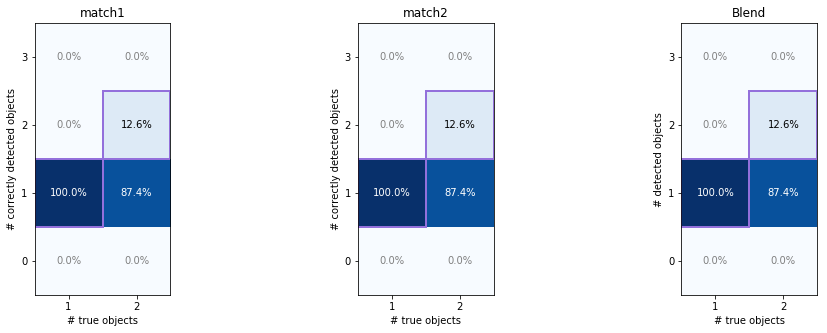

In [5]:
num = np.array(detection_summary).max()

_, ax = plt.subplots(1,3,figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#match1
det_summary = np.array(detection_summary)
tot = np.sum(det_summary[:, 0])
det = np.sum(det_summary[:, 1])
spur = np.sum(det_summary[:, 3])
print("match1", "precision: ", float(det/(det + spur)), "recall: ", float(det/(tot)))
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[0])
ax[0].set_title('match1')
    
# match 2
summ = np.array(detection_summary)
det_summary = np.concatenate([summ[:, 0, np.newaxis], summ[:, 5:]], axis=1)
tot = np.sum(det_summary[:, 0])
det = np.sum(det_summary[:, 1])
spur = np.sum(det_summary[:, 3])

print("match2", "precision: ", float(det/(det + spur)), "recall: ", float(det/(tot)))
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[1])
ax[1].set_title('match2')

summ = np.array(detection_summary)
det_summary = np.concatenate([summ[:, 0, np.newaxis], summ[:, 5:]], axis=1)
det_summary[:, 1] += det_summary[:, 3] +det_summary[:, 4]
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[2])
ax[2].set_title('Blend')
ax[2].set_ylabel('# detected objects')

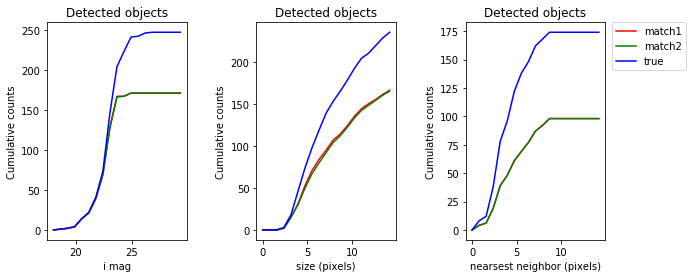

In [6]:
_, axs = plt.subplots(1,3,figsize=(10,4))
plt.subplots_adjust(wspace=0.5, hspace=0.)
mag_bins = np.linspace(18, 30, 20)
size_bins = np.linspace(0, 15, 20)
dist_bins = np.linspace(0, 15, 20)
# match1
true_table['min_dist'][np.isinf(true_table['min_dist'])] =128
q_detected, = np.where(true_table['num_detections1'] ==1)
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table[q_detected], 'i_ab', axs[0],
                           mag_bins, color='r', xlabel='i mag', label='match1')
# Plot by size
btk.plot_utils.plot_cumulative(true_table[q_detected], 'size', axs[1],
                           size_bins, color='r', xlabel='size (pixels)', label='match1')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table[q_detected], 'min_dist', axs[2],
                           dist_bins, color='r', xlabel='nearsest neighbor (pixels)', label='match1')
# match2
true_table['min_dist'][np.isinf(true_table['min_dist'])] = 128
q_detected, = np.where(true_table['num_detections2'] ==1)
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table[q_detected], 'i_ab', axs[0],
                           mag_bins, color='g', xlabel='i mag', label='match2')
# Plot by size
btk.plot_utils.plot_cumulative(true_table[q_detected], 'size', axs[1],
                           size_bins, color='g', xlabel='size (pixels)', label='match2')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table[q_detected], 'min_dist', axs[2],
                           dist_bins, color='g', xlabel='nearsest neighbor (pixels)', label='match2')
#true entries
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table, 'i_ab', axs[0],
                           mag_bins, color='blue', xlabel='i mag', label='true')
# Plot by size
btk.plot_utils.plot_cumulative(true_table, 'size', axs[1],
                           size_bins, color='blue', xlabel='size (pixels)', label='true')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table, 'min_dist', axs[2],
                           dist_bins, color='blue', xlabel='nearsest neighbor (pixels)', label='true')
axs[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_title("Detected objects")
axs[1].set_title("Detected objects")
axs[2].set_title("Detected objects")
plt.show()

Similarly, detectection metrics can be computed for two other simultion parametrs 

## 2. Upto 10 galaxy blends created randomly from CatSim galaxies

`btk_input.py` input arg `--multi_gal` simulates galaxy blends using the `btk.utils.default_sampling` function with maximum of 10 galaxies per blend.

In [ ]:
!python3 ../btk_input.py --simulation multi_gal --configfile ../input/example-config.yaml

## 3. Blends as galaxy "groups" from a pre-processed wld output

In [ ]:
!python3 ../btk_input.py --simulation group --configfile ../input/example-config.yaml

`btk_input.py` input arg `--multi_gal` simulates galaxy blends using the `btk.utils.group_sampling_function` function with maximum of 6 galaxies per blend.

In [ ]:
If `/btk_input.py` is run with input arg `--simulation all` then all three simulations :two-gal, multi-gal, group are run.